# Data import

## Library definition

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
class SliceMeasurement:
    
    def __init__(self, utm_path, fsr_path):
        self.utm_path = utm_path
        self.fsr_path = fsr_path
        
    def dataImport(self):
        utm_meas = pd.read_csv(self.utm_path, skiprows=11)
        self.utm_force = utm_meas["(N)"].squeeze().reset_index(drop=True).to_numpy()
        
        logger = pd.read_csv(self.fsr_path, skiprows=5).dropna()
        fsr_voltage = logger["C1 DC (V)"].squeeze()[::-1].reset_index(drop=True).to_numpy()
        
        self.fsr_v_filt = np.delete(fsr_voltage, np.where(fsr_voltage < 0.25))

        ## Normalize (Min-Max) vectors
        self.utm_norm = (self.utm_force-np.min(self.utm_force))/(np.max(self.utm_force)-np.min(self.utm_force))
        self.fsr_norm = (self.fsr_v_filt-np.min(self.fsr_v_filt))/(np.max(self.fsr_v_filt)-np.min(self.fsr_v_filt))
        
    def crossCorrelation(self):
        
        self.dataImport()
        
        standard_length = len(self.utm_norm)
        size_difference = len(self.fsr_norm) - standard_length

        correlation = np.zeros(size_difference)

        for i in range (size_difference):
            trimmed_sample = self.fsr_norm[i : standard_length + i]
            correlation[i] = np.corrcoef(self.utm_norm, trimmed_sample)[1,0]
            
        max_corr_index = np.where(correlation == max(correlation))[0][0]
        self.fsr_max_corr = self.fsr_v_filt[max_corr_index : standard_length + max_corr_index]
        
        return self.utm_force, self.fsr_max_corr
    
    def derivativeCriteria(self):
        
        self.dataImport()
        
        standard_length = len(self.utm_norm)
        fsr_diff = np.diff(self.fsr_norm[0:1000])
        slice_index = (np.where(fsr_diff == max(fsr_diff))[0][0])
        
        self.fsr_der = self.fsr_v_filt[slice_index : standard_length + slice_index]
        
        return self.utm_force, self.fsr_der

In [3]:
# Function to calculate the power law y = ax^b + c
def powerLaw(x, a, b, c):
    return a*np.power(x,b) + c

# Function for the quadratic fitting y = ax^2 + bx + c
def quadraticFit(x, a, b, c):
    return a*x**2 + b*x + c

# Function to calculate the power law y = x^a * e^(b*x) + c
def powerLawExponential(x, a, b, c):
    return np.power(x,a) * np.exp(b * x) + c

def regressionStatistics(x, y, f):
    ## Bootstrap Monte Carlo confidence intervals computation
    nboot = 100 # number of boots
    bspreds = np.zeros((nboot, y.size)) # bootstrap predictions

    for i in range(nboot):
        xb,yb = bootstrap(x,y)
        pars, cov = curve_fit(f,xb,yb)
        bspreds[i] = f(x,*pars)
        


    # Fit the curve with all the points
    pars, cov = curve_fit(f, x, y)
    # Standard deviation of the constants
    stdev = np.sqrt(np.diag(cov))

    # Get the estimated curve
    y_hat = f(x, *pars)


    # Statistical parameters
    n = len(y) # number of data points
    p = len(pars) # number of parameters

    dof = max(0, n-p) # number of degrees of freedom

    res = y - y_hat # Residuals
    RSS = np.sum((res)**2) # Residual sum of squares -> chi^2
    variance = RSS/dof # mean residual variance, reduced chi^2
    RMSE = np.sqrt(variance)
    TSS = np.sum(y**2)
    R2 = 1 - (RSS/TSS)
    
    
    
    """
    # Parameters confidence region
    alpha = 0.05 # 95% Confidence interval 100*(1-alpha)
    # student-t value for the dof and confidence level (covers for the uncertainty in the sample)
    tval = t.ppf(1.0 - alpha/2., dof)

    # parameters confidence interval
    pars_max = pars + tval * stdev
    pars_min = pars - tval * stdev
    ax1.fill_between(x, powerLaw(x, *pars_min), powerLaw(x, *pars_max), alpha=0.1)
    """
    
    
    
    return y_hat, bspreds, variance, RMSE, R2

### Data import of one sensor acquisition example

Import UTM measurement example 1

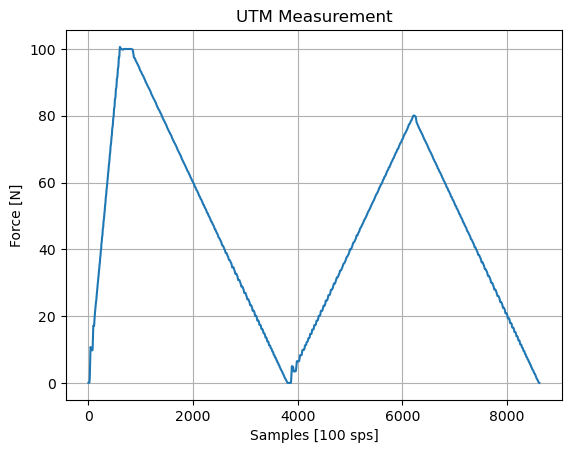

In [4]:
## UTM data import
### Skip the machine header
utm_meas = pd.read_csv('fsr_no_pluck_utm/Specimen_RawData_1.csv', skiprows=11)
utm_force = utm_meas["(N)"].squeeze().reset_index(drop=True).to_numpy()
plt.figure()
plt.plot(utm_force)
plt.grid()
plt.title("UTM Measurement")
plt.xlabel("Samples [100 sps]")
plt.ylabel("Force [N]")
plt.show()

Import data logger example 1

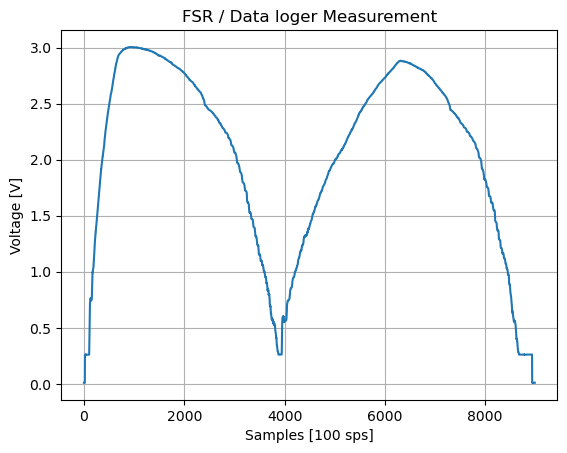

In [5]:
## Data logger import
### Skip logger header
logger = pd.read_csv('fsr_no_pluck_acq/FSR_no_pluck_1.csv', skiprows=5).dropna()
fsr_voltage = logger["C1 DC (V)"].squeeze()[::-1].reset_index(drop=True).to_numpy()
plt.figure()
plt.plot(fsr_voltage)
plt.grid()
plt.title("FSR / Data loger Measurement")
plt.xlabel("Samples [100 sps]")
plt.ylabel("Voltage [V]")
plt.show()

Clean the lowest part of the acquisition knowing that the minimum value possible is 0.25 V by sensor design

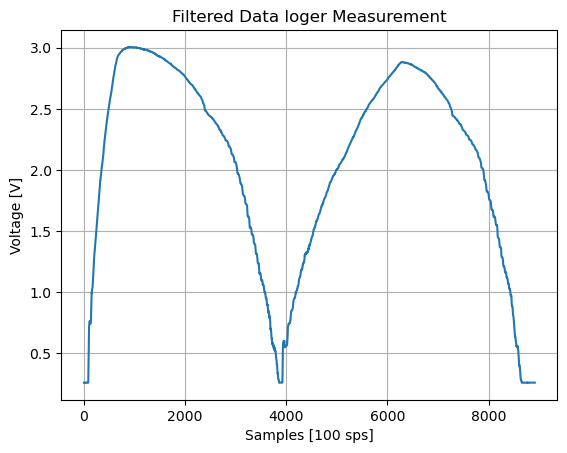

In [6]:
fsr_v_filt = np.delete(fsr_voltage, np.where(fsr_voltage < 0.25))
plt.plot(fsr_v_filt)
plt.grid()
plt.title("Filtered Data loger Measurement")
plt.xlabel("Samples [100 sps]")
plt.ylabel("Voltage [V]")
plt.show()

### Data slicing based on max correlation example

In [7]:
## Normalize (Min-Max) vectors
utm_norm = (utm_force-np.min(utm_force))/(np.max(utm_force)-np.min(utm_force))
fsr_norm = (fsr_v_filt-np.min(fsr_v_filt))/(np.max(fsr_v_filt)-np.min(fsr_v_filt))

Maximize cross-correlation

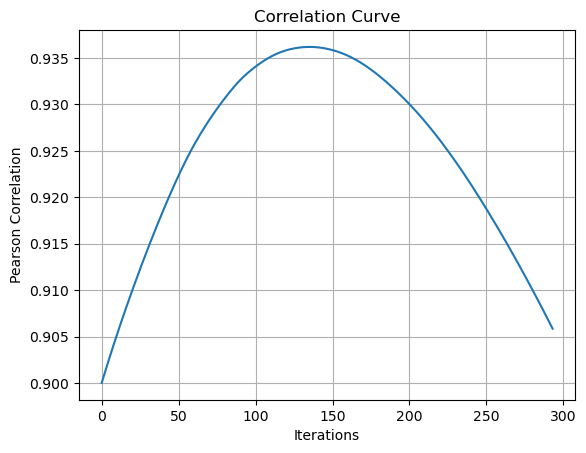

The maximum correlation index is 135


In [8]:
standard_length = len(utm_norm)
size_difference = len(fsr_norm) - standard_length

correlation = np.zeros(size_difference)

for i in range (size_difference):
    trimmed_sample = fsr_norm[i : standard_length + i]
    correlation[i] = np.corrcoef(utm_norm, trimmed_sample)[1,0]

plt.figure()
plt.plot(correlation)
plt.grid()
plt.title("Correlation Curve")
plt.xlabel("Iterations")
plt.ylabel("Pearson Correlation")
plt.show()

# Slice the logger data based on the max correlation point
max_corr_index = np.where(correlation == max(correlation))[0][0]
print("The maximum correlation index is {}".format(max_corr_index))

Show the correlated plots

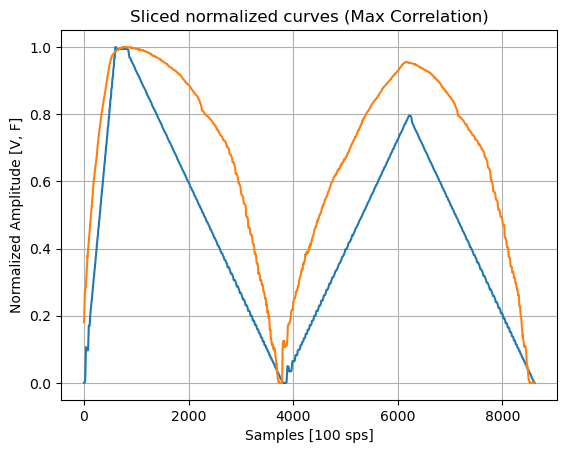

In [9]:
## Show the correlated plots
plt.figure()
plt.plot(utm_norm)
plt.plot(fsr_norm[max_corr_index : standard_length + max_corr_index])
plt.grid()
plt.title("Sliced normalized curves (Max Correlation)")
plt.xlabel("Samples [100 sps]")
plt.ylabel("Normalized Amplitude [V, F]")
plt.show()

Slice original voltage data vector

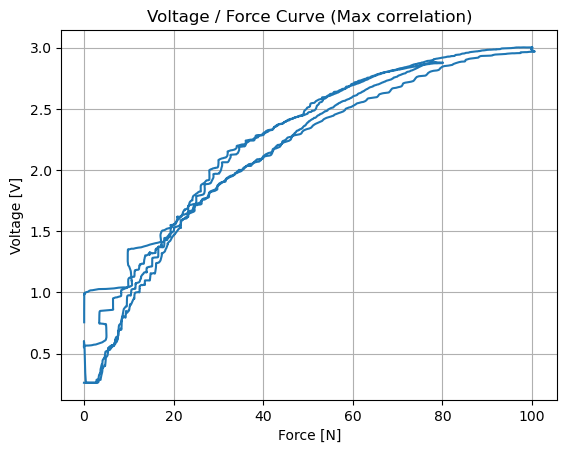

In [10]:
fsr_max_corr = fsr_v_filt[max_corr_index : standard_length + max_corr_index]

plt.figure()
plt.plot(utm_force, fsr_max_corr)
plt.grid()
plt.title("Voltage / Force Curve (Max correlation)")
plt.xlabel("Force [N]")
plt.ylabel("Voltage [V]")
plt.show()

## Process all the acquisition folders

Define the sample directory

In [11]:
directory_utm = 'fsr_no_pluck_utm'
directory_fsr = 'fsr_no_pluck_acq'

utm_path = []
fsr_path = []

Get all the files inside the directories

In [12]:
for filename in glob.iglob(f'{directory_utm}/*'):
    utm_path.append(filename)

for filename in glob.iglob(f'{directory_fsr}/*'):
    fsr_path.append(filename)

Initialize variables

In [13]:
dict_df = {}
keys = range(len(utm_path))

utm_temp = []
fsr_temp = []

Get the data

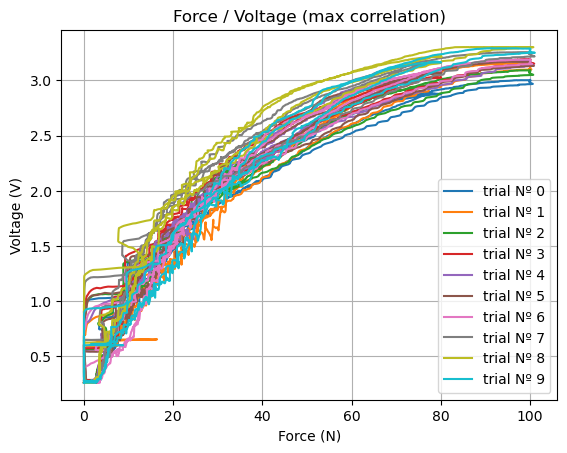

In [14]:
plt.figure()
for i in range(len(utm_path)):
    utm_temp, fsr_temp = SliceMeasurement(utm_path[i],fsr_path[i]).crossCorrelation()
    label = "trial Nº {}"
    plt.plot(utm_temp, fsr_temp, label=label.format(i))
    dict_df[i] = pd.DataFrame({'N': utm_temp, 'V': fsr_temp})
    
## Convert trials into dataframes
trials_max_correlation = pd.concat(dict_df, axis=1)
    
plt.title("Force / Voltage (max correlation)")
plt.xlabel("Force (N)")
plt.ylabel("Voltage (V)")
plt.grid()
plt.legend()
plt.show()

In [15]:
trials_max_correlation = pd.concat(dict_df)
trials = trials_max_correlation.reset_index(drop=True)

In [16]:
trials.head()

,N,V
0,0.04630,0.755447
1,0.04593,0.756973
2,0.04689,0.760621
3,0.04458,0.765984
4,0.04664,0.784863


In [17]:
trials.tail()

,N,V
86580,0.09241,0.280736
86581,0.06078,0.281604
86582,0.03207,0.281857
86583,0.00020,0.281989
86584,-0.00005,0.282228


**All the trials are combined into one **

# Preprocessing

## Moving average filter

In [18]:
ma_trials = trials.rolling(50).mean()
ma_trials.dropna(inplace=True)

In [19]:
ma_trials

,N,V
49,4.202917,0.985791
50,4.412741,0.993628
51,4.621959,1.001599
52,4.830447,1.009707
53,5.038128,1.017914
...,...,...
86580,0.868802,0.276548
86581,0.838398,0.276602
86582,0.808481,0.276668
86583,0.778841,0.276746


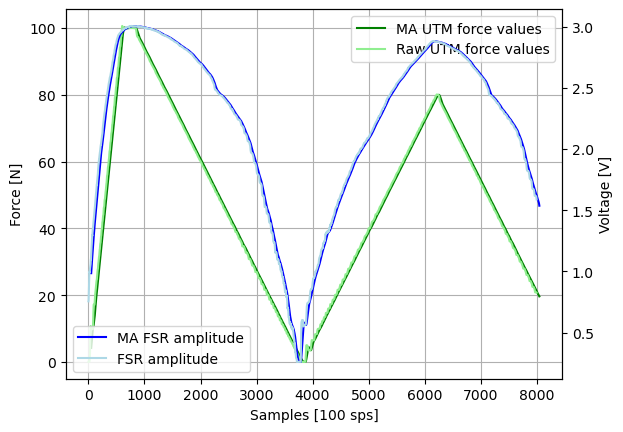

In [20]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Samples [100 sps]')
ax1.set_ylabel('Force [N]')
ax1.plot(ma_trials.N[0:8000], label='MA UTM force values', color='green')
ax1.plot(trials.N[0:8000], label='Raw UTM force values', color='lightgreen')




ax2 = ax1.twinx()

ax2.set_ylabel('Voltage [V]')
ax2.plot(ma_trials.V[0:8000], label='MA FSR amplitude', color='blue')
ax2.plot(trials.V[0:8000], label='FSR amplitude', color='lightblue')


ax1.grid()
ax1.legend()
ax2.legend()




## Low-Pass filter (20 Hz)